In [34]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [35]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    plt.figure()
    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [36]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
orig = cv2.imread('cropped_panda.jpg')[..., ::-1]
print(orig.shape)

orig = cv2.resize(orig, (224, 224))

print(orig.shape)
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = torch.from_numpy(img).to(device).float()
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()
label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))

(100, 100, 3)
(224, 224, 3)
torch.Size([1, 3, 224, 224])
label=388


In [37]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
target=288
target=torch.Tensor([float(target)]).to(device).long()

for epoch in range(epochs):
    # 梯度清零
    optimizer.zero_grad()

    # forward + backward
    output = model(img)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())

    print("epoch={} loss={} label={}".format(epoch,loss,label))
    #如果定向攻击成功
    if label == target:
        break
    loss.backward()
    optimizer.step()

epoch=0 loss=12.659987449645996 label=388
epoch=1 loss=11.617764472961426 label=388
epoch=2 loss=10.711429595947266 label=388
epoch=3 loss=9.92906379699707 label=388
epoch=4 loss=9.274702072143555 label=388
epoch=5 loss=8.724475860595703 label=388
epoch=6 loss=8.258914947509766 label=388
epoch=7 loss=7.857677936553955 label=388
epoch=8 loss=7.491978645324707 label=388
epoch=9 loss=7.16623067855835 label=388
epoch=10 loss=6.862151145935059 label=388
epoch=11 loss=6.567148208618164 label=388
epoch=12 loss=6.273365497589111 label=388
epoch=13 loss=5.980749607086182 label=388
epoch=14 loss=5.69752311706543 label=388
epoch=15 loss=5.39663553237915 label=388
epoch=16 loss=5.089109420776367 label=388
epoch=17 loss=4.78673791885376 label=388
epoch=18 loss=4.472159385681152 label=388
epoch=19 loss=4.16541862487793 label=388
epoch=20 loss=3.8590927124023438 label=388
epoch=21 loss=3.561476945877075 label=388
epoch=22 loss=3.2665460109710693 label=388
epoch=23 loss=2.9752628803253174 label=293
ep

(3, 224, 224)
[[[ 75  71  70]
  [ 75  72  70]
  [ 75  73  72]
  ...
  [177 209 230]
  [177 208 229]
  [177 208 229]]

 [[ 79  74  73]
  [ 78  75  74]
  [ 78  76  75]
  ...
  [178 209 230]
  [177 208 229]
  [177 208 229]]

 [[ 88  84  83]
  [ 87  84  83]
  [ 86  84  82]
  ...
  [178 210 230]
  [178 209 230]
  [177 209 229]]

 ...

 [[ 95 139 115]
  [ 95 139 115]
  [ 95 139 116]
  ...
  [113 102  80]
  [113 102  80]
  [113 102  80]]

 [[ 95 139 114]
  [ 95 139 114]
  [ 95 139 114]
  ...
  [111 100  78]
  [112 101  79]
  [112 101  79]]

 [[ 95 139 114]
  [ 95 139 114]
  [ 95 139 114]
  ...
  [110  99  77]
  [111 100  78]
  [112 101  79]]]


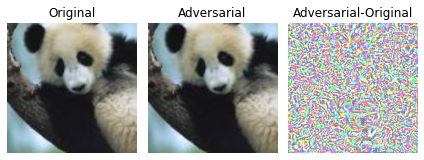

In [38]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
#adv = adv[..., ::-1]  # RGB to BGR
adv = np.clip(adv, 0, 255).astype(np.uint8)
show_images_diff(orig,388,adv,target.data.cpu().numpy()[0])